In [1]:
# Comes from Analytics Vidhya Site (https://datahack.analyticsvidhya.com/contest/practice-problem-loan-prediction-iii/)

# Goal is to predict loan status (Y or N) based on a range of features about the applicant
# We will be building models to predict this class based on features  
# Then we will use those models to predict the classes of a hold-out set to see how well they perform

# This is a multi-class classification problem

# We will be using the following types of models:
#    * Logistic regression
#    * K Nearest Neighbors
#    * Gaussian Naive Bayes
#    * Random Forest
#    * XG Boost


In [2]:
# Import libraries for manipulating and visualizing data
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import mode
from collections import Counter

#libraries for preparing datasets for modeling 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import model_selection

#libraries to build machine learning models 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


# libraries for assessing model performance
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

# libraries I didn't need here but am keeping for later reference
#from datetime import datetime
#from datetime import date

#from sklearn import datasets
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import Normalizer
#from sklearn.tree import DecisionTreeClassifier
#from sklearn import svm
#import xgboost as xgb
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#import lightgbm as lgbm
#from sklearn.metrics import log_loss
#from pandas.plotting import scatter_matrix

In [85]:
# import data 
train=pd.read_csv('train.csv',delimiter=',',encoding='utf-8')
test = pd.read_csv('test.csv',delimiter=',',encoding='utf-8')
sample = pd.read_csv('sample_submission.csv',delimiter=',',encoding='utf-8')


In [86]:
train[0:5]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [87]:
test[0:5]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [88]:
sample[0:5]

,Loan_ID,Loan_Status


In [89]:
# Looks like the data came over fine.  Let's explore to see what's there

In [90]:
############################
###### UNDERSTAND DATA #####
############################

In [91]:
train.shape

(614, 13)

In [92]:
test.shape
# Significant amount of hold-out values

(367, 12)

In [93]:
train.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [94]:
test.isnull().sum()

Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64

In [95]:
# Let's look at each of these features in a little more depth

In [96]:
# Loan_ID is going to be a unique number assigned to the loan.  Let's make sure:

In [97]:
train['Loan_ID'].nunique()

614

In [98]:
test['Loan_ID'].nunique()

367

In [99]:
# Yep

In [100]:
# Gender should hopefully be M or F

In [101]:
train['Gender'].unique()  #yes, but there are NANs

array(['Male', 'Female', nan], dtype=object)

In [102]:
# Married should be Y or N

In [103]:
train['Married'].unique()  #yes, but there are NANs

array(['No', 'Yes', nan], dtype=object)

In [104]:
# Dependents may vary a bit

In [105]:
train['Dependents'].unique()  #yes, either 0,1,2,3+ or NAN (missing values)

array(['0', '1', '2', '3+', nan], dtype=object)

In [106]:
test['Dependents'].unique() 

array(['0', '1', '2', '3+', nan], dtype=object)

In [107]:
# Education - not sure.  2 values

In [108]:
train['Education'].unique()

array(['Graduate', 'Not Graduate'], dtype=object)

In [109]:
test['Education'].unique()

array(['Graduate', 'Not Graduate'], dtype=object)

In [110]:
# Self_Employed should be two values

In [111]:
train['Self_Employed'].unique()  # there are NAN values here too.  Missing

array(['No', 'Yes', nan], dtype=object)

In [112]:
# Credit history - number of years probably varies a lot

In [113]:
train['Credit_History'].unique() # 3 values.  Looks like some missing


array([ 1.,  0., nan])

In [114]:
train['Property_Area'].unique() # 3 values

array(['Urban', 'Rural', 'Semiurban'], dtype=object)

In [115]:
# Dependent variable assessment

train['Loan_Status'].nunique()

# Two different values we have to predict.  This is a binomial classification problem.

2

In [116]:
train.groupby('Loan_Status').size()

# There are a lot more yeses than no's (2:1)

Loan_Status
N    192
Y    422
dtype: int64

In [117]:
# Let's look at the continuous variables
train.describe()

# There should be 614 observations.  Note that Loan Amount, Loan Amount Term and Credit History all have missing values
# ApplicantIncome has a HUGE range - 150 to 81,000. Low and high values are possible outliers

# CoapplicantIncome also varies widely.  A lot of people have none, but a few have a huge one

# Loan_Amount_Term has a few very low values, but most are much longer (3-4 years)

# Credit history varies from 0 to 1, with an average close to 1

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [118]:
##################################
###### HANDLE MISSING VALUES #####
##################################


# I'd love to drop them all, but the test set has a lot.  So simply dropping them is not an option.
# Will need to infer them.

# Option 1: Fill NA values with 0.    data.fillna(0) 
# Option 2: Fill NA values with median.  dataset.fillna(dataset.mean(), inplace=True) -> This didn't work
# Option 3: Fill NA values with the mode.
# There must be a better way to do this, but let's go with this for now# 

In [119]:
mode(train['Gender']).mode[0]

'Male'

In [120]:
train['Gender'].fillna(mode(train['Gender']).mode[0], inplace=True)
test['Gender'].fillna(mode(test['Gender']).mode[0], inplace=True)

In [121]:
mode(train['Married']).mode[0]

'Yes'

In [122]:
train['Married'].fillna(mode(train['Married']).mode[0], inplace=True)
test['Married'].fillna(mode(test['Married']).mode[0], inplace=True)

In [123]:
mode(train['Dependents']).mode[0]

'0'

In [124]:
train['Dependents'].fillna(mode(train['Dependents']).mode[0], inplace=True)
test['Dependents'].fillna(mode(test['Dependents']).mode[0], inplace=True)

In [125]:
mode(train['Self_Employed']).mode[0]

'No'

In [126]:
train['Self_Employed'].fillna(mode(train['Self_Employed']).mode[0], inplace=True)
test['Self_Employed'].fillna(mode(test['Self_Employed']).mode[0], inplace=True)

In [127]:
mode(train['LoanAmount']).mode[0]

120.0

In [128]:
train['LoanAmount'].fillna(mode(train['LoanAmount']).mode[0], inplace=True)
test['LoanAmount'].fillna(mode(test['LoanAmount']).mode[0], inplace=True)

In [129]:
train['Loan_Amount_Term'].fillna(mode(train['Loan_Amount_Term']).mode[0], inplace=True)
test['Loan_Amount_Term'].fillna(mode(test['Loan_Amount_Term']).mode[0], inplace=True)

In [130]:
train['Credit_History'].fillna(mode(train['Credit_History']).mode[0], inplace=True)
test['Credit_History'].fillna(mode(test['Credit_History']).mode[0], inplace=True)

In [131]:
train.isnull().sum()


Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [132]:
test.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64

In [133]:
# Got rid of the NANs

In [134]:
train.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [135]:
#####################################################
###### CONVERT CATEGORICAL VARIABLES TO NUMERIC #####
#####################################################

In [136]:
# At this point, we have clean datasets with numerous columns with categorical data.  We could already use decision
# tree classification on this.  However, if we want to use logistic regression, KNN, or SVM, we need these values to
# be numeric.  I'm going to one-hot-encode all of the categorical variables

In [137]:
# One hot encode columns with categorical variables
train1 = pd.get_dummies(train, columns=['Gender', 'Married', 'Dependents', 'Education', 
                                        'Self_Employed', 'Property_Area'])

In [138]:
test1 = pd.get_dummies(test, columns=['Gender', 'Married', 'Dependents', 'Education', 
                                        'Self_Employed', 'Property_Area'])

In [139]:
train1['Loan_Status'] = train1['Loan_Status'].replace(to_replace=['N', 'Y'], value=['0', '1'])

In [140]:
train1[0:5]

,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Female,Gender_Male,Married_No,...,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,LP001002,5849,0.0,120.0,360.0,1.0,1,0,1,1,...,0,0,0,1,0,1,0,0,0,1
1,LP001003,4583,1508.0,128.0,360.0,1.0,0,0,1,0,...,1,0,0,1,0,1,0,1,0,0
2,LP001005,3000,0.0,66.0,360.0,1.0,1,0,1,0,...,0,0,0,1,0,0,1,0,0,1
3,LP001006,2583,2358.0,120.0,360.0,1.0,1,0,1,0,...,0,0,0,0,1,1,0,0,0,1
4,LP001008,6000,0.0,141.0,360.0,1.0,1,0,1,1,...,0,0,0,1,0,1,0,0,0,1


In [141]:
test1[0:5]

,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Married_No,Married_Yes,...,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,LP001015,5720,0,110.0,360.0,1.0,0,1,0,1,...,0,0,0,1,0,1,0,0,0,1
1,LP001022,3076,1500,126.0,360.0,1.0,0,1,0,1,...,1,0,0,1,0,1,0,0,0,1
2,LP001031,5000,1800,208.0,360.0,1.0,0,1,0,1,...,0,1,0,1,0,1,0,0,0,1
3,LP001035,2340,2546,100.0,360.0,1.0,0,1,0,1,...,0,1,0,1,0,1,0,0,0,1
4,LP001051,3276,0,78.0,360.0,1.0,0,1,1,0,...,0,0,0,0,1,1,0,0,0,1


In [142]:
train1['Loan_Status'] = train1['Loan_Status'].astype(int)

In [143]:
train1.dtypes

Loan_ID                     object
ApplicantIncome              int64
CoapplicantIncome          float64
LoanAmount                 float64
Loan_Amount_Term           float64
Credit_History             float64
Loan_Status                  int64
Gender_Female                uint8
Gender_Male                  uint8
Married_No                   uint8
Married_Yes                  uint8
Dependents_0                 uint8
Dependents_1                 uint8
Dependents_2                 uint8
Dependents_3+                uint8
Education_Graduate           uint8
Education_Not Graduate       uint8
Self_Employed_No             uint8
Self_Employed_Yes            uint8
Property_Area_Rural          uint8
Property_Area_Semiurban      uint8
Property_Area_Urban          uint8
dtype: object

In [144]:
test1.dtypes

Loan_ID                     object
ApplicantIncome              int64
CoapplicantIncome            int64
LoanAmount                 float64
Loan_Amount_Term           float64
Credit_History             float64
Gender_Female                uint8
Gender_Male                  uint8
Married_No                   uint8
Married_Yes                  uint8
Dependents_0                 uint8
Dependents_1                 uint8
Dependents_2                 uint8
Dependents_3+                uint8
Education_Graduate           uint8
Education_Not Graduate       uint8
Self_Employed_No             uint8
Self_Employed_Yes            uint8
Property_Area_Rural          uint8
Property_Area_Semiurban      uint8
Property_Area_Urban          uint8
dtype: object

In [145]:
train1.shape

(614, 22)

In [146]:
test1.shape

(367, 21)

In [147]:
# Now all of the values are numeric... finally.  Let's skip the data analysis and jump right into modeling

In [148]:
#################################
####### DATA EXPLORATION  #######
#################################

In [149]:
#train1.corr()

# doesn't really tell us much.  Loan Status is most correlated to credit history.  
# Nothing else is close, but the property being semi-urban is a distant #2

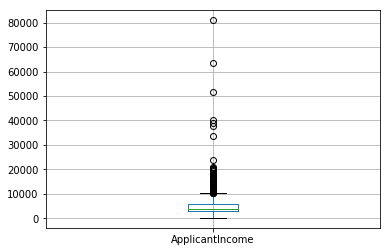

In [150]:
train1.boxplot(column=['ApplicantIncome'])

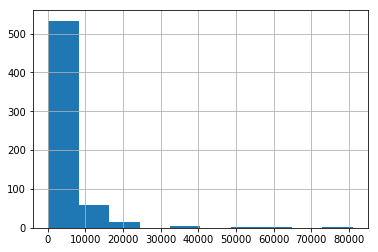

In [151]:
train1['ApplicantIncome'].hist()

# Consider capping this at 25k

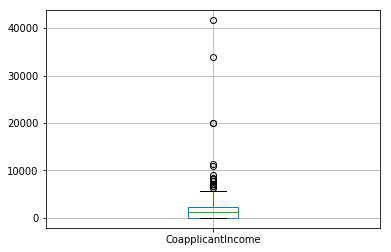

In [152]:
train1.boxplot(column=['CoapplicantIncome'])

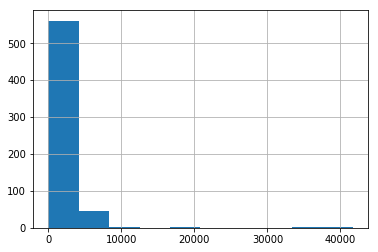

In [153]:
train1['CoapplicantIncome'].hist()

# Consider capping this at 10k

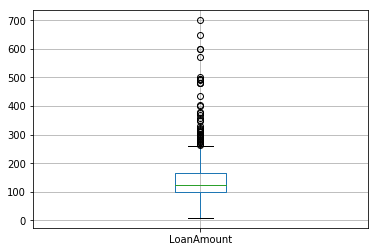

In [154]:
train1.boxplot(column=['LoanAmount'])

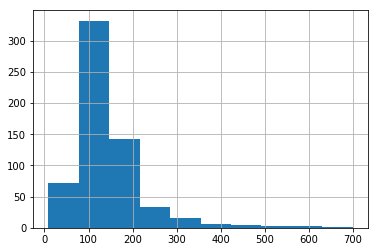

In [155]:
train1['LoanAmount'].hist()

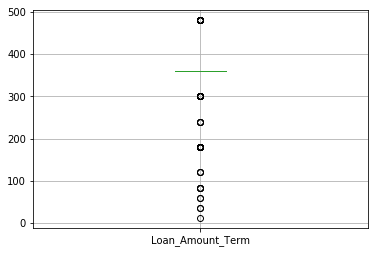

In [156]:
train1.boxplot(column=['Loan_Amount_Term'])

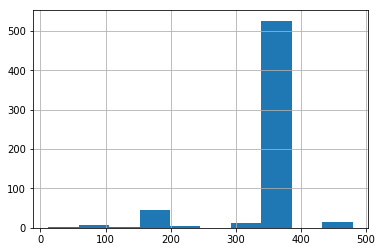

In [157]:
train1['Loan_Amount_Term'].hist()

In [158]:
###########################################################
############# SET CAPS AND FLOORS ON THE DATA #############
###########################################################

# The data is so significantly above and below the average that it could potentially have a massive impact on the models

In [159]:
train1['ApplicantIncome'] = train1['ApplicantIncome'].clip(0, 25000)
test1['ApplicantIncome'] = test1['ApplicantIncome'].clip(0, 25000)

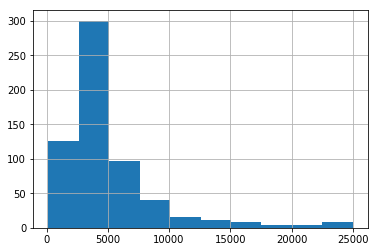

In [160]:
train1['ApplicantIncome'].hist()

In [161]:
train1['CoapplicantIncome'] = train1['CoapplicantIncome'].clip(0, 10000)
test1['CoapplicantIncome'] = test1['CoapplicantIncome'].clip(0, 10000)

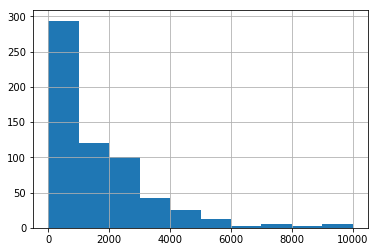

In [162]:
train1['CoapplicantIncome'].hist()

In [163]:
def detect_outliers(df,n,features):
    outlier_indices = []
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col],25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index       
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    return multiple_outliers   

In [164]:
Outliers_to_drop = detect_outliers(train1,1,['ApplicantIncome','CoapplicantIncome','LoanAmount'])

In [165]:
train1.loc[Outliers_to_drop] # Show the outliers rows

,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Female,Gender_Male,Married_No,...,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
9,LP001020,12841,10000.0,349.0,360.0,1.0,0,0,1,0,...,1,0,0,1,0,1,0,0,1,0
34,LP001100,12500,3000.0,320.0,360.0,1.0,0,0,1,1,...,0,0,1,1,0,1,0,1,0,0
54,LP001186,11500,0.0,286.0,360.0,0.0,0,1,0,0,...,1,0,0,1,0,0,1,0,0,1
67,LP001233,10750,0.0,312.0,360.0,1.0,1,0,1,0,...,1,0,0,1,0,1,0,0,0,1
126,LP001448,23803,0.0,370.0,360.0,1.0,1,0,1,0,...,0,0,1,1,0,1,0,1,0,0
130,LP001469,20166,0.0,650.0,480.0,1.0,1,0,1,1,...,0,0,0,1,0,0,1,0,0,1
155,LP001536,25000,0.0,600.0,180.0,0.0,1,0,1,0,...,0,0,1,1,0,1,0,0,1,0
171,LP001585,25000,0.0,700.0,300.0,1.0,1,0,1,0,...,0,0,1,1,0,1,0,0,0,1
258,LP001859,14683,2100.0,304.0,360.0,1.0,0,0,1,0,...,0,0,0,1,0,1,0,1,0,0
278,LP001907,14583,0.0,436.0,360.0,1.0,1,0,1,0,...,0,0,0,1,0,1,0,0,1,0


In [166]:
# NO ACTION TAKEN FOR NOW. LET'S SEE IF THE MODELS GET BETTER OR NOT

In [167]:
####################################################
####### CREATE TRAINING AND VALIDATION SETS  #######
####################################################

# Let's create training and validation sets now before we explore.  We are artificially creating a set for use
# in data science.  This dataset is actually complete, and we could simply analyze it and try to understand the 
# differences.  Instead, we're going to try to predict the class based on a subset of the data

In [168]:
Y = train1[train1.columns[6]]

In [169]:
X = train1
X = X.drop(['Loan_ID','Loan_Status'], axis=1)

In [170]:
X.shape

(614, 20)

In [171]:
Y.shape

(614,)

In [172]:
validation_size = 0.20
seed = 1

In [173]:
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)



In [174]:
# If we remove 20% of the values, that's around 120 values.  So training should be 614-120 = 490 rows
X_train.shape

(491, 20)

In [175]:
X_train[0:5]

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
291,4400,0.0,127.0,360.0,0.0,0,1,0,1,0,0,1,0,1,0,1,0,0,1,0
507,3583,0.0,96.0,360.0,1.0,0,1,1,0,1,0,0,0,1,0,1,0,0,0,1
328,4333,2451.0,110.0,360.0,1.0,1,0,0,1,1,0,0,0,1,0,1,0,0,0,1
609,2900,0.0,71.0,360.0,1.0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,0
69,4300,0.0,136.0,360.0,0.0,1,0,1,0,1,0,0,0,1,0,1,0,0,1,0


In [176]:
Y_train.shape

(491,)

In [177]:
Y_train[0:5]

291    0
507    0
328    0
609    1
69     0
Name: Loan_Status, dtype: int64

In [178]:
X_validation.shape

(123, 20)

In [179]:
Y_validation.shape

(123,)

In [180]:
####################################################
#######    BUILD MACHINE LEARNING MODELS     #######
####################################################

In [181]:
# We are going to split the X_train data into 10 splits.  9 will be used for the training and 1 will be used to validate
# The process will run 10 times and then average the scores across all of the runs

In [182]:
kfold = model_selection.KFold(n_splits=10, random_state=seed)
scoring = 'accuracy'


In [183]:
#######################################################################################################################
##### 1.  LOGISTIC REGRESSION (specifically a multinomial logistic regression aka multiclass logistic regression) #####
#######################################################################################################################

# Logistic regression is normally used for binary classification.
# It uses a logistic function (S-curve, sigmoid function) that is restricted between 0 and 1.
# There are a few different steps in terms of how this is calculated... provide the detail later.
# For more than two classes, multinomial logistic regression can be done, but linear discriminant analysis (LDA) 
# typically provides better results

# In a multinomial regression with 3 targets, 3 logistic regression models are run.  0 and 1, 1 and 2, and 0 and 2.
# The highest probability classification out of the three models is selected as the prediction.


In [184]:
# Run the logistic regression model using cross validation with 10 folds
cv_results_LR = model_selection.cross_val_score(LogisticRegression(solver='liblinear'), X_train, Y_train, cv=kfold, scoring=scoring)


In [185]:
# Identify the accuracy (this is the mean of all 10 runs of the model)
cv_results_LR.mean()

0.8086530612244898

In [186]:
######################################################
####### 2. K NEAREST NEIGHBORS Classifier      #######
######################################################

# Super simple.  Each point is classified based on its nearest neighbor(s). 
# You can specify how many neighbors to look at using the K value
# Whichever classification is most common amongst the K neighbors is how that point is classified.

In [187]:
cv_results_KNN = model_selection.cross_val_score(KNeighborsClassifier(), X_train, Y_train, cv=kfold, scoring='accuracy')

In [188]:
cv_results_KNN.mean()

0.6375102040816326

In [189]:
############################################
####### 3. GAUSSIAN NAIVE BAYES      #######
############################################

In [190]:
cv_results_NB = model_selection.cross_val_score(GaussianNB(), X_train, Y_train, cv=kfold, scoring='accuracy')

In [191]:
cv_results_NB.mean()

0.7984489795918368

In [192]:
###############################################
####### 5. SUPPORT VECTOR MACHINES      #######
###############################################

In [193]:
cv_results_SVM = model_selection.cross_val_score(SVC(gamma='auto'), X_train, Y_train, cv=kfold, scoring='accuracy')

In [194]:
cv_results_SVM.mean()

0.6924489795918367

In [195]:
#####################################
####### 6. RANDOM FOREST      #######
#####################################

In [196]:
cv_results_RF = model_selection.cross_val_score(RandomForestClassifier(n_estimators=150), X_train, Y_train, cv=kfold, scoring='accuracy')


In [197]:
cv_results_RF.mean()

0.802530612244898

In [198]:
################################
####### 7. XG BOOST      #######              FAILS - IT USED TO WORK AND BE GOOD.  HAVE NOT TOUCHED IT
################################

In [ ]:
# cv_results_XG = model_selection.cross_val_score(XGBClassifier(n_estimators=50), X_train, Y_train, cv=kfold, scoring='accuracy')


# Stuff to try later if this continues not to work
#cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=10,
#                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)
#
#xg_reg = xgb.XGBClassifier(colsample_bytree = 0.3, learning_rate = 0.1,
#                max_depth = 5, alpha = 10, n_estimators = 10)

In [ ]:
cv_results_XG.mean()

In [ ]:
# The best performing models were Logistic Regression, XG Boost, Random Forest, and Naive Bayes in that order

In [ ]:
##########################################
########## MAKE PREDICTIONS ##############
##########################################


In [ ]:
test1[0:5]

In [ ]:
test2 = test1.drop(['Loan_ID'], axis=1)

In [ ]:
test2[0:5]

In [ ]:
########### PREDICTION - LOGISTIC REGRESSION ###############

## UNFORTUNATELY THIS CONTINUES TO FAIL

#lr = LogisticRegression()
#lr.fit(X_train, Y_train)
#predictions = lr.predict(test2)


In [ ]:
########### PREDICTION - GAUSSIAN NAIVE BAYES ###############

GNB = GaussianNB()
GNB.fit(X_train, Y_train)
predictions_GNB = GNB.predict(test2)

In [ ]:
########### PREDICTION - RANDOM FOREST ###############

RF = RandomForestClassifier(n_estimators=150)
RF.fit(X_train, Y_train)
predictions_RF = RF.predict(test2)


In [1]:
########### PREDICTION - XGBOOST ###############     SINCE CLASSIFIER FAILS, AM COMMENTING THIS OUT FOR NOW
#XG = XGBClassifier(n_estimators=50)
#XG.fit(X_train, Y_train)
#predictions_XG = XG.predict(test2)

NameError: name 'XGBClassifier' is not defined

In [111]:
####################################
##### BLENDING THE PREDICTIONS #####
####################################

# We have three different models with roughly equivalent results.  Can blending them help?

In [112]:
predictions_GNB

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,

In [113]:
blended_predictions = pd.DataFrame(data=predictions_GNB)

In [114]:
blended_predictions['RF'] = pd.DataFrame(data=predictions_RF)

In [115]:
blended_predictions['XG'] = pd.DataFrame(data=predictions_XG)

In [116]:
blended_predictions = blended_predictions.rename(columns = {0:'GNB'})

In [117]:
blended_predictions[0:4]

,GNB,RF,XG
0,1,1,1
1,1,1,1
2,1,1,1
3,1,1,1


In [118]:
blended_predictions['mode'] = blended_predictions.mode(axis=1)

In [119]:
blended_predictions[0:4]

,GNB,RF,XG,mode
0,1,1,1,1
1,1,1,1,1
2,1,1,1,1
3,1,1,1,1


In [120]:
blended_predictions.shape

(367, 4)

In [121]:
test['Loan_ID'].shape

(367,)

In [ ]:
#########################################
####### SUBMITTING OUTPUT FILES #########
#########################################


In [122]:
sample['Loan_ID'] = test['Loan_ID']

In [133]:
sample['Loan_Status'] = blended_predictions['mode']
sample['Loan_Status'] = sample['Loan_Status'].replace(to_replace=[0, 1], value=['N', 'Y'])

In [134]:
sample.to_csv("blended_model.csv",index=False)

In [135]:
# Now submit the other three models individually
sample['Loan_Status'] = blended_predictions['GNB']
sample['Loan_Status'] = sample['Loan_Status'].replace(to_replace=[0, 1], value=['N', 'Y'])
sample.to_csv("GNB.csv",index=False)

In [136]:
sample['Loan_Status'] = blended_predictions['RF']
sample['Loan_Status'] = sample['Loan_Status'].replace(to_replace=[0, 1], value=['N', 'Y'])
sample.to_csv("RF.csv",index=False)

In [137]:
sample['Loan_Status'] = blended_predictions['XG']
sample['Loan_Status'] = sample['Loan_Status'].replace(to_replace=[0, 1], value=['N', 'Y'])
sample.to_csv("XG.csv",index=False)